In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import os
from collections import OrderedDict
import uproot
import pandas as pd
import sys
import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
wH = 1
Z_MASS = 91.2
# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [4]:
limitTrees = OrderedDict()
dataCards = OrderedDict()
limitTrees10 = OrderedDict()
dataCards10 = OrderedDict()
version = '/V1p17/v1/v9/'
dc_version = 'v1'
nrechit = 130
dphi = 'dPhiCluster0p75'
bdt_name = 'cut_based_v4'
limitDir = os.environ['HOME'] + '/login-1/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine_gdituri/limitTrees/'\
 + version + '/' + bdt_name + '/' + dc_version + '/'
dataCardDir = os.environ['HOME'] + '/login-1/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine_gdituri/datacards/'\
 + version + '/' + bdt_name+'/' + dc_version + '/'

lumi = 137000
ctaus = np.array([10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 5000,])
samples = ['ggH_HToSS_SToEE_ms0p1_pl500', 'ggH_HToSS_SToPi0Pi0_ms1_pl500', 'ggH_HToSS_SToPiPlusPiMinus_ms1_pl500',
           'ggH_HToSS_SToKPlusKMinus_ms1p5_pl500','ggH_HToSSTobbbb_ms1_pl1000' , 
           'ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000', 'ggH_HToSS_SToEE_ms0p4_pl500', 
           'ggH_HToSSTo4Tau_MH-125_MS-7_ctau-1000']
for sample in samples:
    limitTrees[sample] = {}
    dataCards[sample] = {}
    for ct in ctaus:
        limitTrees[sample][ct] = limitDir + 'higgsCombine.'+ sample +'_ctau'+ str(ct) + 'mm_nRechit'+ str(nrechit) + dphi + '.AsymptoticLimits.mH120.root'
        dataCards[sample][ct] = dataCardDir + sample +'_ctau'+ str(ct) + 'mm_nRechit'+ str(nrechit)+ dphi +'.txt'
norms = []
limits = {}
for i,m in enumerate(limitTrees.keys()):
    for j, k in enumerate(limitTrees[m].keys()):
        T = uproot.open(limitTrees[m][k])['limit']
        line = open(dataCards[m][k], "r").readline()
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:limit_temp = np.ones((6,))*100000
        else:limit_temp = np.array(T.array('limit'))/signal_norm
        if j == 0: limits[m] = limit_temp
        else: limits[m] = np.vstack((limits[m], limit_temp))
    limits[m] = np.array(limits[m])
print(ctaus)

[  10   20   30   40   50   60   80  100  200  300  500 1000 5000]


# load atlas limit

In [5]:
file_dir = os.environ['HOME'] + '/login-1/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/limits_others/'
ms1_40 = file_dir + 'atlas_mh125_mx40_ms1.csv'
ms2_40 = file_dir + 'atlas_mh125_mx40_ms2.csv'
id55 = file_dir + 'atlas_mh125_mx55_id.csv'
comb40 = file_dir + 'atlas_mh125_mx40_id_cr_ms2.csv'
jingyu = file_dir + 'jingyu_mh125_mx55_95p9ifb.csv'
ms_40 = file_dir + 'atlas_mh125_mx40_ms.csv'
ms_15 = file_dir + 'atlas_mh125_mx15_ms.csv'
ms_40 = np.genfromtxt(ms_40, delimiter = ',')
ms_15 = np.genfromtxt(ms_15, delimiter = ',')
ms1_40 = np.genfromtxt(ms1_40, delimiter = ',')
ms2_40 = np.genfromtxt(ms2_40, delimiter = ',')
id55 = np.genfromtxt(id55, delimiter = ',')
comb40 = np.genfromtxt(comb40, delimiter = ',')
jingyu = np.genfromtxt(jingyu, delimiter = ',')
print(comb40.shape)

(130, 2)


# Plot

137 fb^{-1} (13 TeV)


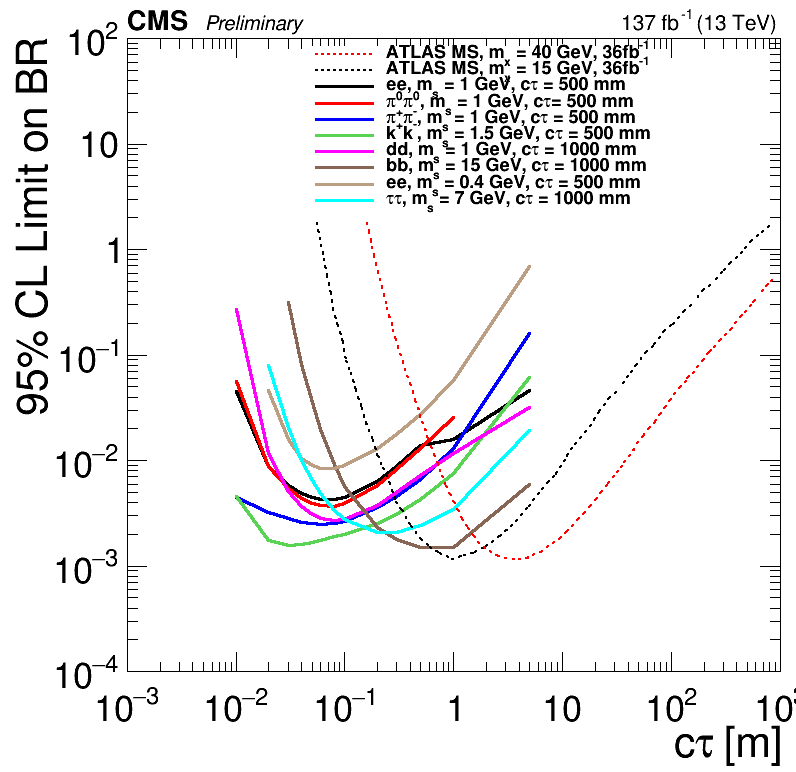

In [6]:
import os
leg = rt.TLegend(0.38, 0.73, 0.8, 0.94)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()
rt.gStyle.SetOptFit(1011)
br = 1
ctaus_m = ctaus/1000
h_others = {}
h = {}
h_others['ms_15'] = create_TGraph(ms_15[:,0],ms_15[:,1],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
h_others['ms_40'] = create_TGraph(ms_40[:,0],ms_40[:,1],  axis_title=['c#tau [m]', '95% CL Limit on BR'])



newLegend = {'ggH_HToSS_SToEE_ms0p1_pl500': 'ee, m_{s} = 1 GeV, c#tau = 500 mm' , 
             'ggH_HToSS_SToPi0Pi0_ms1_pl500': '#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm',
          'ggH_HToSS_SToPiPlusPiMinus_ms1_pl500':'#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm', 
          'ggH_HToSS_SToKPlusKMinus_ms1p5_pl500': 'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', 
             'ggH_HToSSTobbbb_ms1_pl1000':'dd, m_{s} = 1 GeV, c#tau = 1000 mm',
          'ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000':'bb, m_{s} = 15 GeV, c#tau = 1000 mm',
             'ggH_HToSS_SToEE_ms0p4_pl500':'ee, m_{s} = 0.4 GeV, c#tau = 500 mm', 
             'ggH_HToSSTo4Tau_MH-125_MS-7_ctau-1000':'#tau#tau, m_{s} = 7 GeV, c#tau = 1000 mm'}

leg.AddEntry(h_others['ms_40'], "ATLAS MS, m_{x} = 40 GeV, 36fb^{-1}", 'L')
leg.AddEntry(h_others['ms_15'], "ATLAS MS, m_{x} = 15 GeV, 36fb^{-1}", 'L')
for i, m in enumerate(limits.keys()):
    cond = limits[m][:,2] < 1
    h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h[m].SetLineColor(std_color_list[i])
    h[m].SetLineWidth(3)
    h[m].GetXaxis().SetLimits(0.001,1000.0)
    h[m].GetYaxis().SetRangeUser(1e-4,100)
    h[m].GetXaxis().SetTitleOffset(1)
    leg.AddEntry(h[m], newLegend[m], "L")
    h[m].Draw('LA' if i == 0 else 'Lsame')

for i, k in enumerate(h_others.keys()): 
    h_others[k].SetLineWidth(2)
    h_others[k].SetLineColor(std_color_list[i])
    h_others[k].SetLineStyle(2)
    h_others[k].Draw('Lsame')

tdrstyle.setTDRStyle()
CMS_lumi.cmsText = "CMS"
iPos = 0
CMS_lumi.writeExtraText = True
CMS_lumi.extraText   = "Preliminary"
if(iPos==0 ): CMS_lumi.relPosX = 0.12
CMS_lumi.CMS_lumi(c, 4, 0)
leg.Draw()
c.SetLogy()
c.SetLogx()
c.Draw()


# limit for different mass points